In [44]:
import pandas as pd
import datetime
import time
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler

In [45]:
def get_data(pair, t_start, t_stop, bin_size):
    time_step = 60000000
    limit = 1000
    df = {}
    path = f'./data/{pair}_{t_start}-{t_stop}_{bin_size}.csv'
    if (os.path.exists(path)) and (os.path.isfile(path)):
        df = pd.read_csv(path, index_col=0)
    else:
        data = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=bin_size, tick_limit=limit, step=time_step)
        names = ['time', 'open', 'close', 'high', 'low', 'volume']
        df = pd.DataFrame(data, columns=names)
        df.drop_duplicates(inplace=True)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
        print(df.head())
        df.to_csv(f'./data/{pair}_{t_start}-{t_stop}_{bin_size}.csv')
    return df

In [46]:
t_start = datetime.datetime(2019, 11, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime.datetime(2019, 12, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

df = get_data(pair='btcusd', t_start=t_start, t_stop=t_stop, bin_size='1m')
df.head()

,open,close,high,low,volume
time,,,,,
2019-10-31 23:00:00,9158.900000,9159.000000,9159.000000,9152.900000,0.216948
2019-10-31 23:01:00,9157.000000,9152.600000,9160.000000,9152.600000,0.160750
2019-10-31 23:02:00,9151.971187,9148.960156,9154.400000,9147.398881,0.295918
2019-10-31 23:03:00,9149.400000,9149.000000,9149.400000,9149.000000,0.020000
2019-10-31 23:04:00,9151.371226,9151.342113,9151.378378,9151.342113,0.020960


In [47]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

35006 8752


In [48]:
f_columns = ['open', 'high', 'low', 'volume']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())

train.loc[:, f_columns] = f_transformer.transform(
  train[f_columns].to_numpy()
)

test.loc[:, f_columns] = f_transformer.transform(
  test[f_columns].to_numpy()
)

cnt_transformer = RobustScaler()

cnt_transformer = cnt_transformer.fit(train[['close']])

train['close'] = cnt_transformer.transform(train[['close']])

test['close'] = cnt_transformer.transform(test[['close']])


C:\Users\Husar\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Husar\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Husar\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [49]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [50]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.close, time_steps)
X_test, y_test = create_dataset(test, test.close, time_steps)

print(X_train.shape, y_train.shape)

(34996, 10, 5) (34996,)


In [51]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    shuffle=False
)

Train on 27996 samples, validate on 7000 samples
Epoch 1/10
27996/27996 [==============================] - 15s 548us/sample - loss: 0.0116 - val_loss: 0.1633
Epoch 2/10
27996/27996 [==============================] - 8s 303us/sample - loss: 0.0044 - val_loss: 0.0764
Epoch 3/10
27996/27996 [==============================] - 10s 341us/sample - loss: 0.0031 - val_loss: 0.0392
Epoch 4/10
27996/27996 [==============================] - 17s 613us/sample - loss: 0.0022 - val_loss: 0.0245
Epoch 5/10
27996/27996 [==============================] - 13s 448us/sample - loss: 0.0016 - val_loss: 0.0116
Epoch 6/10
27996/27996 [==============================] - 13s 459us/sample - loss: 0.0013 - val_loss: 0.0075
Epoch 7/10
27996/27996 [==============================] - 13s 454us/sample - loss: 0.0011 - val_loss: 0.0042
Epoch 8/10
27996/27996 [==============================] - 12s 427us/sample - loss: 8.8059e-04 - val_loss: 0.0031
Epoch 9/10
27996/27996 [==============================] - 12s 445us/sample -

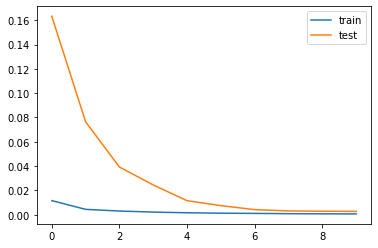

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [54]:
y_pred = model.predict(X_test)
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

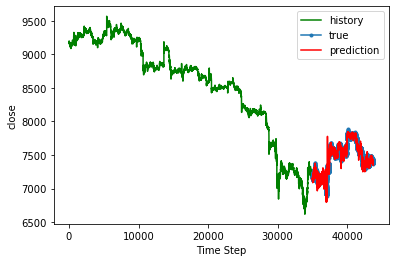

In [55]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

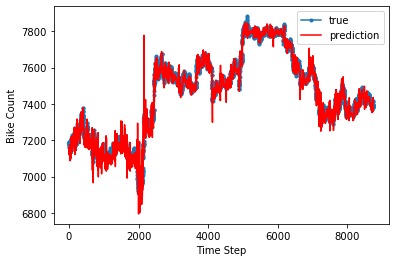

In [57]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [59]:
t_start = datetime.datetime(2019, 6, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime.datetime(2019, 7, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

df_val = get_data(pair='btcusd', t_start=t_start, t_stop=t_stop, bin_size='1m')
df_val.head()

,open,close,high,low,volume
time,,,,,
2019-05-31 22:00:00,8512.9,8512.3,8512.9,8509.1,4.137089
2019-05-31 22:01:00,8509.2,8506.2,8512.9,8506.2,6.812645
2019-05-31 22:02:00,8506.3,8505.0,8506.4,8505.0,11.447399
2019-05-31 22:03:00,8505.0,8488.1,8505.0,8488.0,3.967091
2019-05-31 22:04:00,8488.1,8487.3,8488.1,8487.0,1.350588
